In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
import math
import os
import types

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from utils2d.PDE_Model import PDE_Model
from utils2d.PDE_Model import PDE_Model_2
from utils2d.Preconditioner import Preconditioner
from utils2d.Preconditioner import change_fun

from utils2d.Mesh import Mesh
from utils2d.NeuralNet import PINN_NeuralNet

from utils2d.PINN import PINN
from utils2d.Postprocessing import View_results
from utils2d.PINN import PINN_Precond

from utils2d.XPINN import XPINN
from utils2d.Postprocessing import View_results_X


## PINN

Se resolverá:
$$\nabla^2 u = \frac{1}{\epsilon} \delta(r)$$
$$ 0 <r <1$$
Solución analítica:
$$ u(r) = \frac{1}{2\pi\epsilon}\ln(r) $$

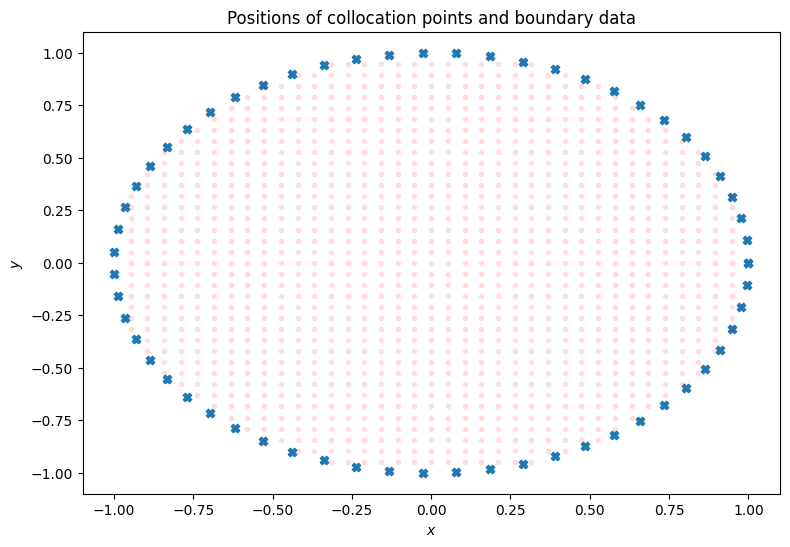

In [18]:
domain1 = ([-1,1],[-1,1])
PDE1 = PDE_Model()
domain1 = PDE1.set_domain(domain1)
PDE1.sigma = 0.04
PDE1.epsilon = 1

lb = {'type':'D', 'value':0, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points();


PINN_solver = PINN()

PINN_solver.adapt_PDE(PDE1)
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
PINN_solver.adapt_mesh(mesh1,**weights)

lr = ([2500,4000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

PINN_solver.create_NeuralNet(PINN_NeuralNet,lr,**hyperparameters)

In [ ]:
PINN_solver.solve(N=5000,flag_time=False)

In [5]:
Post = View_results(PINN_solver)

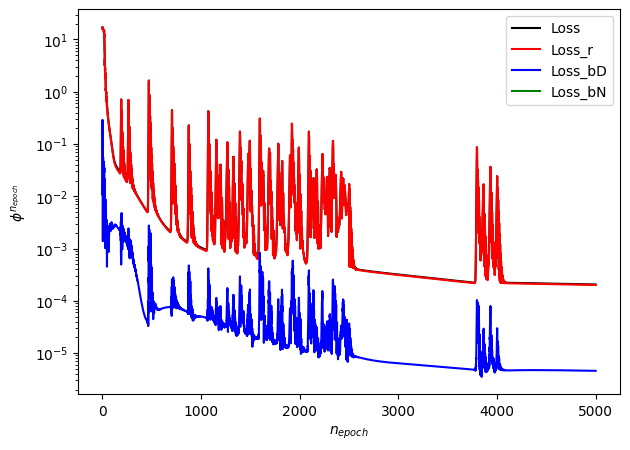

In [6]:
Post.plot_loss_history();

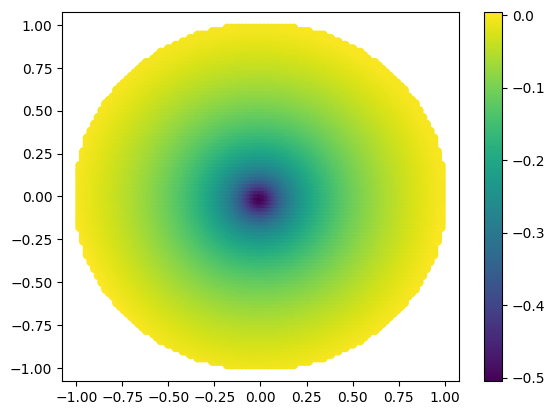

In [7]:
Post.plot_u_domain_contour()

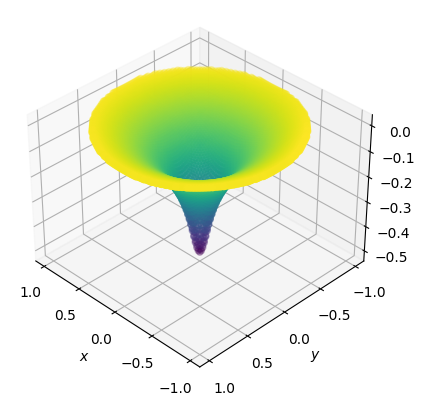

In [8]:
Post.plot_u_domain_surface()

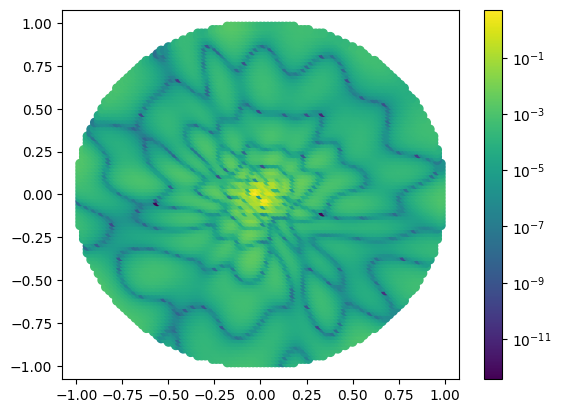

In [9]:
Post.plot_loss();

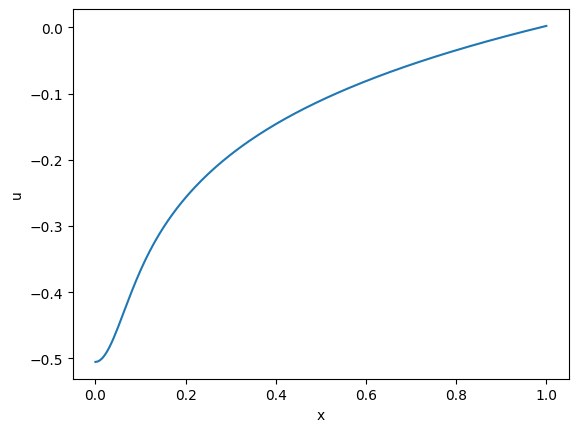

In [10]:
Post.plot_u_plane();

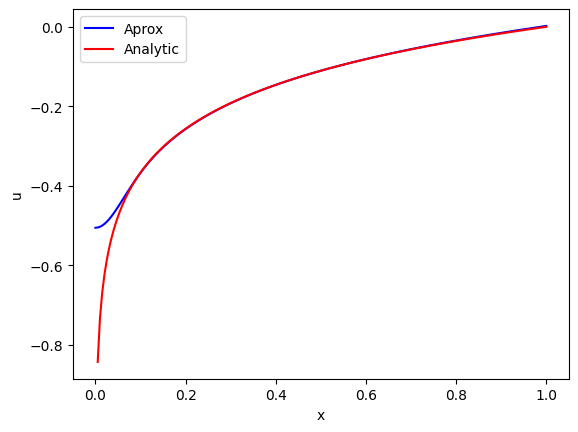

In [11]:
Post.plot_aprox_analytic()

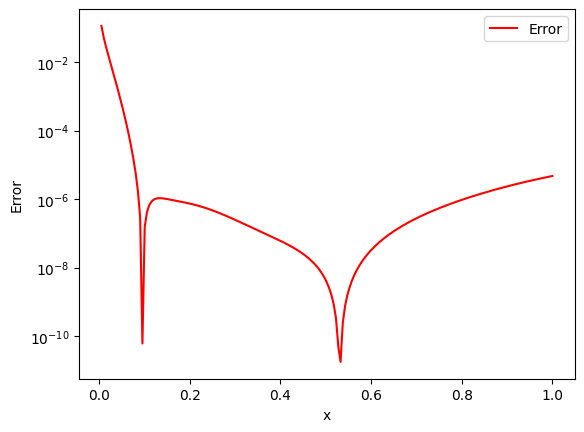

In [12]:
Post.plot_loss_analytic()

## XPINN

Se resolverá un problema con interfaz de la forma:
$$ \nabla^2 u_1 = \frac{1}{\epsilon_1}\delta(r) \: \: \: \: 0<r<1$$
$$ \nabla^2 u_2 = 0 \: \: \: \: 1<r<10$$
En la interfaz:
$$ u_1(r) = u_2(r) \: \: \: \: r=1$$
$$  \epsilon_1\frac{\partial u_1}{\partial r} = \epsilon_2\frac{\partial u_2}{\partial r} \: \: \: \: r=1$$
Con $\epsilon_1=1$, $\epsilon_2=10$
Solución analítica:
$$ u_1(r) = \frac{1}{2\pi\epsilon_1}\ln(r) \: \: \: \: 0 < r \leq 1 $$
$$ u_2(r) = \frac{1}{2\pi\epsilon_2}\ln(r) \: \: \: \: 1<r<10 $$

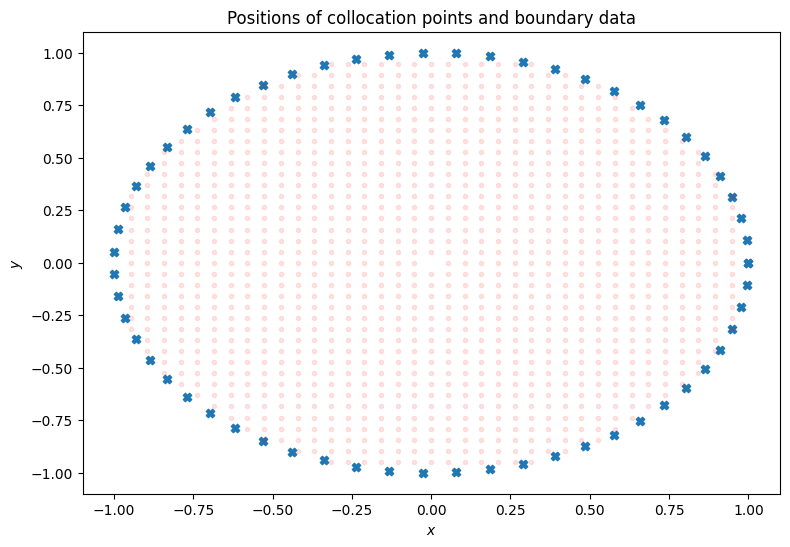

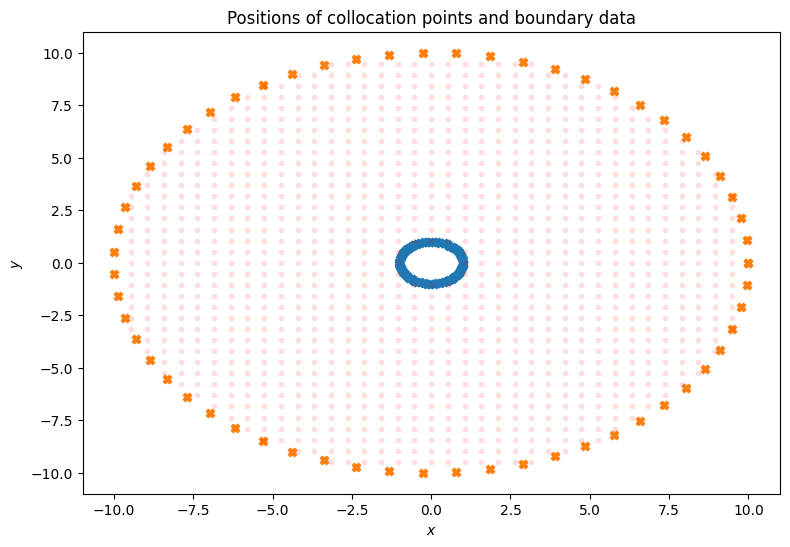

In [3]:
domain1 = ([-1,1],[-1,1])
PDE1 = PDE_Model()
domain1 = PDE1.set_domain(domain1)
PDE1.sigma = 0.04
PDE1.epsilon = 1

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1, 'rmin':0}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points();

PDE2 = PDE_Model_2()
domain2 = ([-10,10],[-10,10])
domain2 = PDE1.set_domain(domain2)
PDE2.sigma = 0.04
PDE2.epsilon = 10

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
lb2 = {'type':'D', 'value':(1.0/(2*np.pi*PDE2.epsilon))*np.log(10), 'fun':None, 'dr':None, 'r':10}
borders = {'1':lb,'2':lb2}
ins_domain = {'rmax': 10,'rmin':1}

mesh2 = Mesh(domain2, N_b=60, N_r=1500)
mesh2.create_mesh(borders, ins_domain)
mesh2.plot_points();

XPINN_solver = XPINN(PINN)

XPINN_solver.adapt_PDEs([PDE1,PDE2],[1,10])
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
XPINN_solver.adapt_meshes([mesh1,mesh2],[weights,weights])

lr = ([2500,3500],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

XPINN_solver.create_NeuralNets(PINN_NeuralNet,[lr,lr],[hyperparameters,hyperparameters])

In [14]:
XPINN_solver.solve(N=3000,flag_time=False)

In [ ]:
Post = View_results_X(XPINN_solver,View_results)

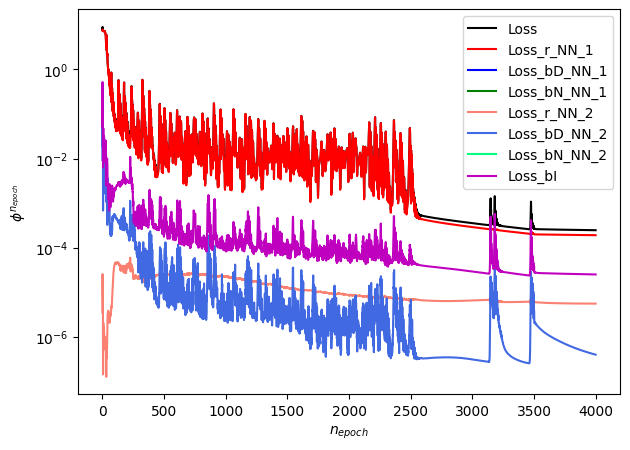

In [ ]:
Post.plot_loss_history();

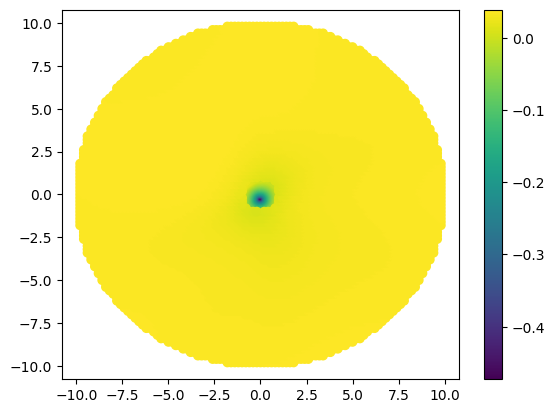

In [ ]:
Post.plot_u_domain_contour()

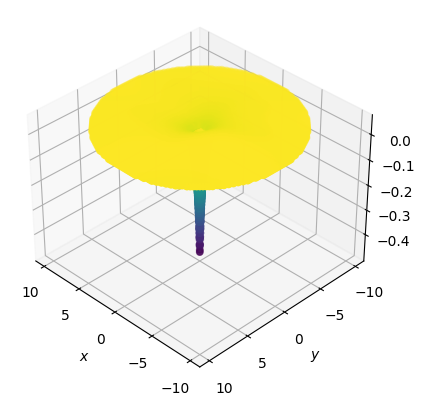

In [ ]:
Post.plot_u_domain_surface()

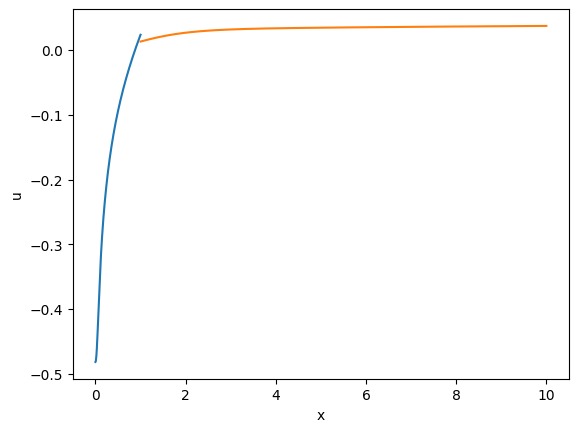

In [ ]:
Post.plot_u_plane();

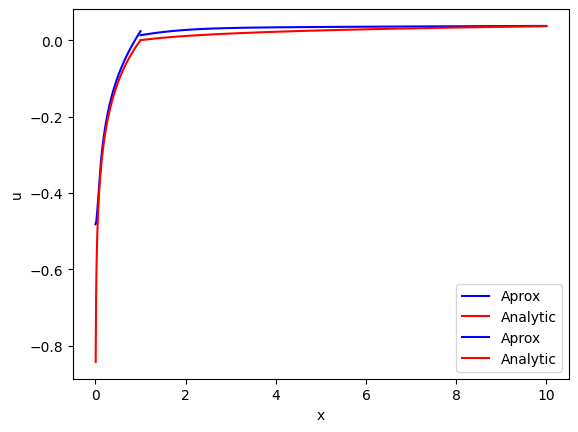

In [ ]:
Post.plot_aprox_analytic()

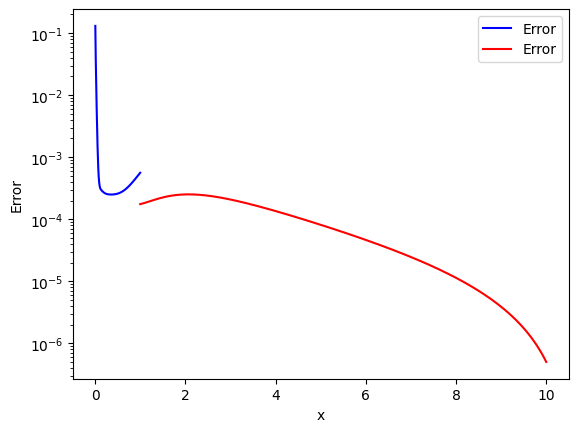

In [ ]:
Post.plot_loss_analytic()

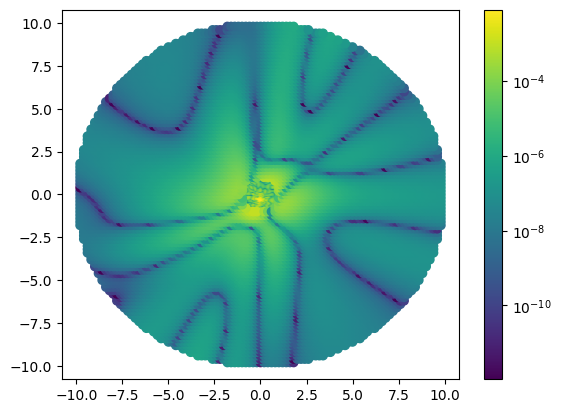

In [ ]:
Post.plot_loss()

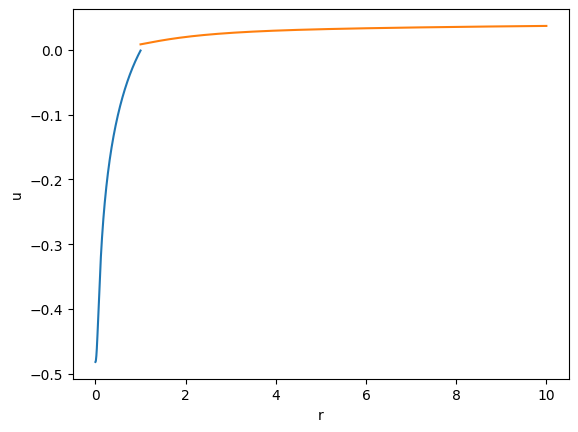

In [ ]:
Post.plot_u_plane_direction(3*np.pi/2)

In [ ]:
XPINN_solver.save_models('.saved_models',['Test_XPINN_int','Test_XPINN_ext'])

Se prueban más iteraciones (a partir del resultado anterior)

In [23]:
XPINN_solver = XPINN(PINN)

domain1 = ([-1,1],[-1,1])
PDE1 = PDE_Model()
domain1 = PDE1.set_domain(domain1)
PDE1.sigma = 0.04
PDE1.epsilon = 1

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1, 'rmin':0}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
#mesh1.plot_points();

PDE2 = PDE_Model_2()
domain2 = ([-10,10],[-10,10])
domain2 = PDE1.set_domain(domain2)
PDE2.sigma = 0.04
PDE2.epsilon = 10

vf = (1/(2*np.pi*PDE2.epsilon))*np.log(10)
lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
lb2 = {'type':'D', 'value':vf, 'fun':None, 'dr':None, 'r':10}
borders = {'1':lb,'2':lb2}
ins_domain = {'rmax': 10,'rmin':1}

mesh2 = Mesh(domain2, N_b=60, N_r=1500)
mesh2.create_mesh(borders, ins_domain)
#mesh2.plot_points();

XPINN_solver = XPINN(PINN)

XPINN_solver.adapt_PDEs([PDE1,PDE2],[1,10])
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
XPINN_solver.adapt_meshes([mesh1,mesh2],[weights,weights])

lr = ([2000],[1e-2,5e-3])
hyperparameters = {
        'input_shape': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

XPINN_solver.load_NeuralNets('.saved_models',['Test_XPINN_int','Test_XPINN_ext'],[lr,lr])

In [24]:
Post = View_results_X(XPINN_solver,View_results)

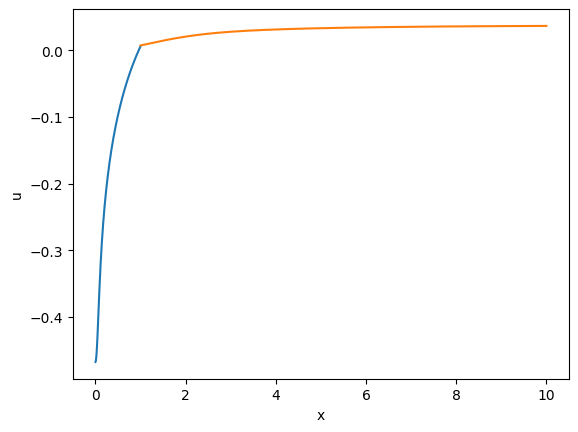

In [25]:
Post.plot_u_plane()

In [26]:
XPINN_solver.solve(N=3000, flag_time=False)

In [27]:
Post = View_results_X(XPINN_solver,View_results)

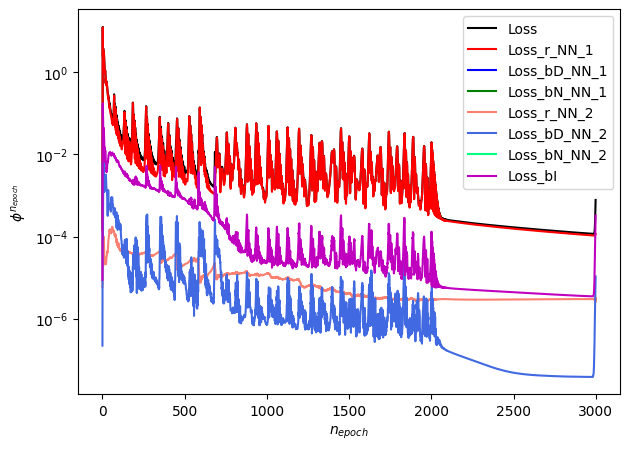

In [28]:
Post.plot_loss_history()

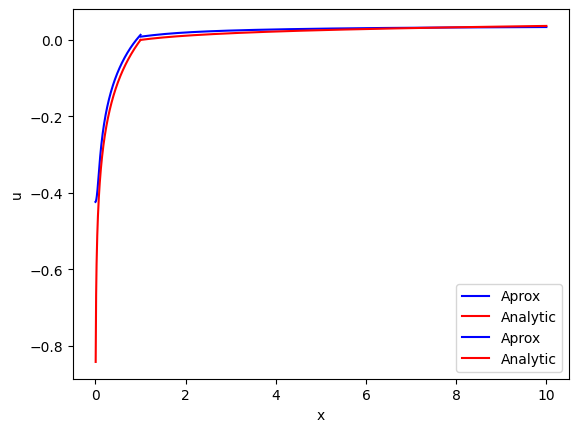

In [29]:
Post.plot_aprox_analytic()

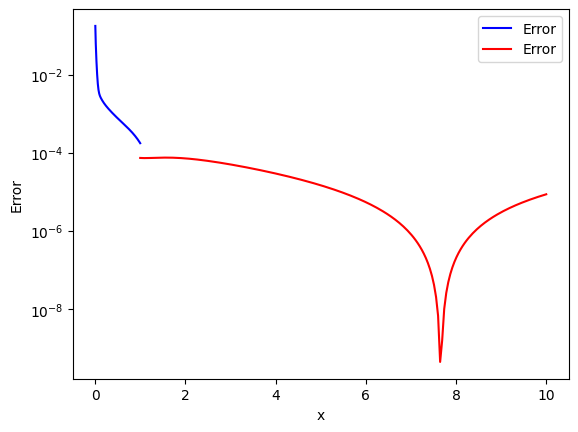

In [30]:
Post.plot_loss_analytic()

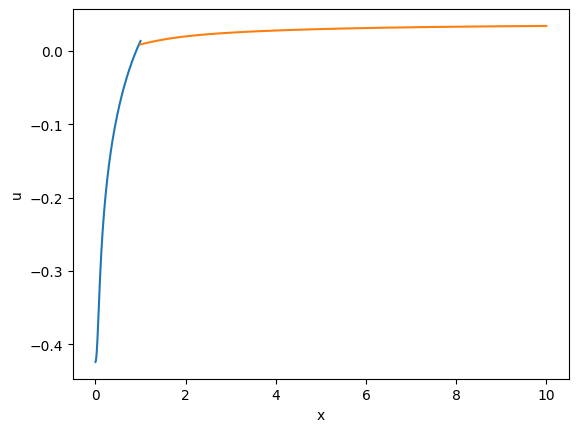

In [31]:
Post.plot_u_plane()

## Preaconditionate XPINN

Se usa preacondicionador
$$ u(r) \approx \frac{1}{\epsilon} \ln(r)  $$

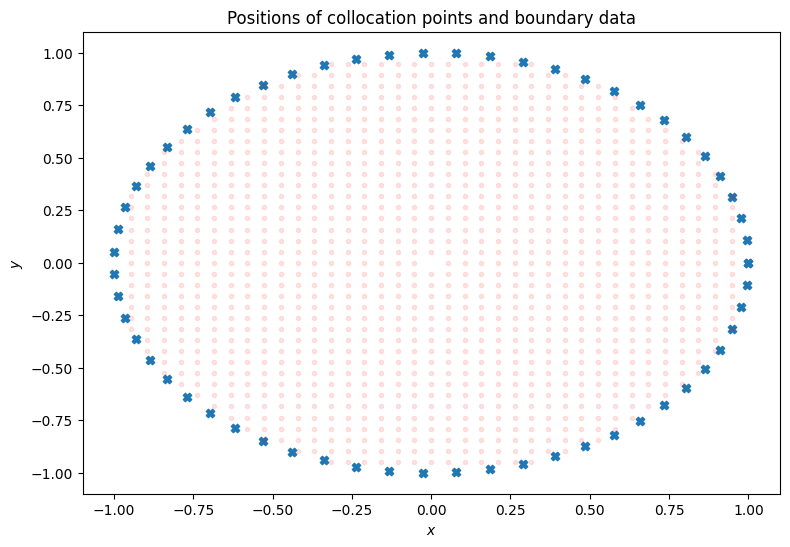

In [62]:
precond1 = Preconditioner()

domain1 = ([-1,1],[-1,1])
domain1 = precond1.set_domain(domain1)
precond1.epsilon = 1
change_fun(precond1, lambda self,x,y: (1/self.epsilon)*tf.math.log(tf.sqrt(x**2+y**2)))

lb = {'type':'D', 'value':0, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1, 'rmin':0.05}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points();


PINN_precond1 = PINN_Precond()

weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
PINN_precond1.adapt_mesh(mesh1,**weights)

lr = ([1000,3000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

PINN_precond1.create_NeuralNet(PINN_NeuralNet,lr,**hyperparameters)

PINN_precond1.load_preconditioner(precond1)

In [63]:
PINN_precond1.preconditionate(N=4000, flag_time=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x000001E9CAA8C2B0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [64]:
Post = View_results(PINN_precond1)

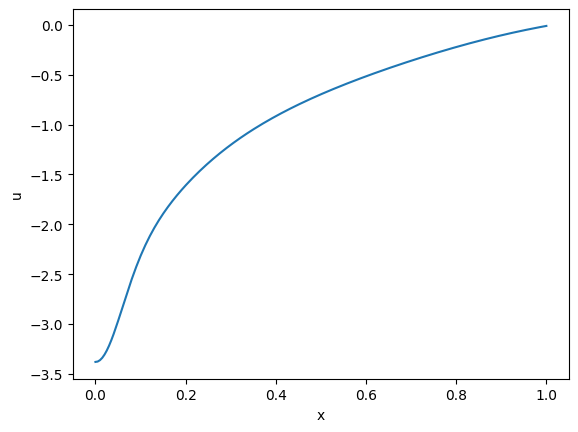

In [65]:
Post.plot_u_plane()

In [66]:
PINN_precond1.save_model('.saved_models','Test_precond_in')

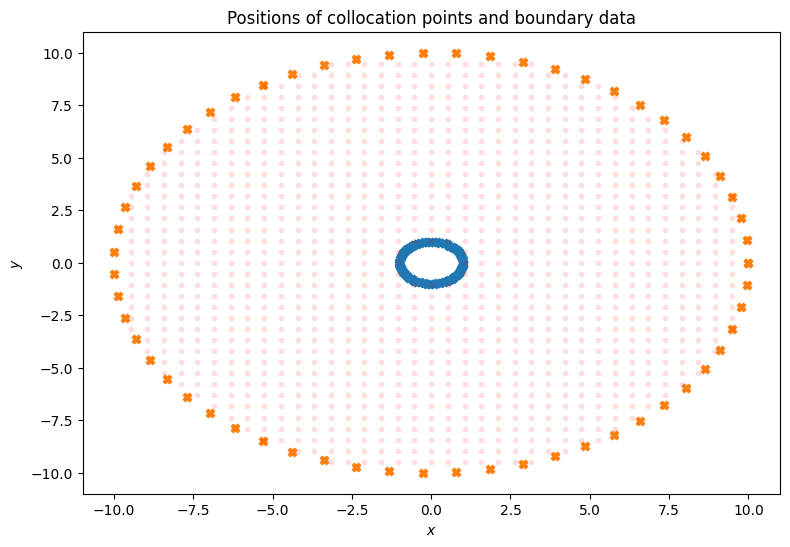

In [67]:
precond2 = Preconditioner()

domain2 = ([-10,10],[-10,10])
domain2 = precond2.set_domain(domain2)
precond2.epsilon = 10
change_fun(precond2, lambda self,x,y: (1/self.epsilon)*tf.math.log(tf.sqrt(x**2+y**2)))

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
lb2 = {'type':'D', 'value':np.log(10), 'fun':None, 'dr':None, 'r':10}
borders = {'1':lb,'2':lb2}
ins_domain = {'rmax': 10,'rmin':1}

mesh2 = Mesh(domain2, N_b=60, N_r=1500)
mesh2.create_mesh(borders, ins_domain)
mesh2.plot_points();


PINN_precond2 = PINN_Precond()

weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
PINN_precond2.adapt_mesh(mesh2,**weights)

lr = ([1000,3000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

PINN_precond2.create_NeuralNet(PINN_NeuralNet,lr,**hyperparameters)

PINN_precond2.load_preconditioner(precond2)



In [68]:
PINN_precond2.preconditionate(N=4000, flag_time=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x000001E9EDAB6D30>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [69]:
Post = View_results(PINN_precond2)

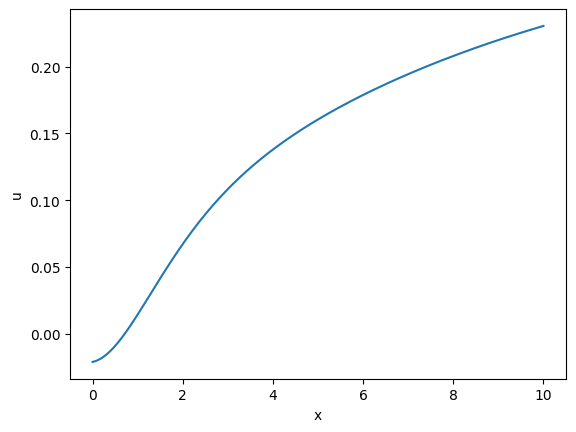

In [70]:
Post.plot_u_plane();

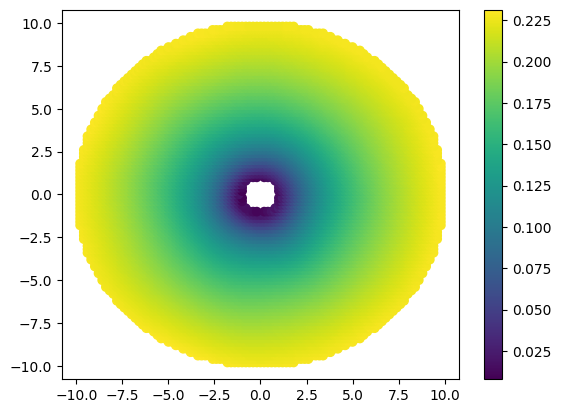

In [71]:
Post.plot_u_domain_contour()

In [72]:
PINN_precond2.save_model('.saved_models','Test_precond_ext')

Se resuelve

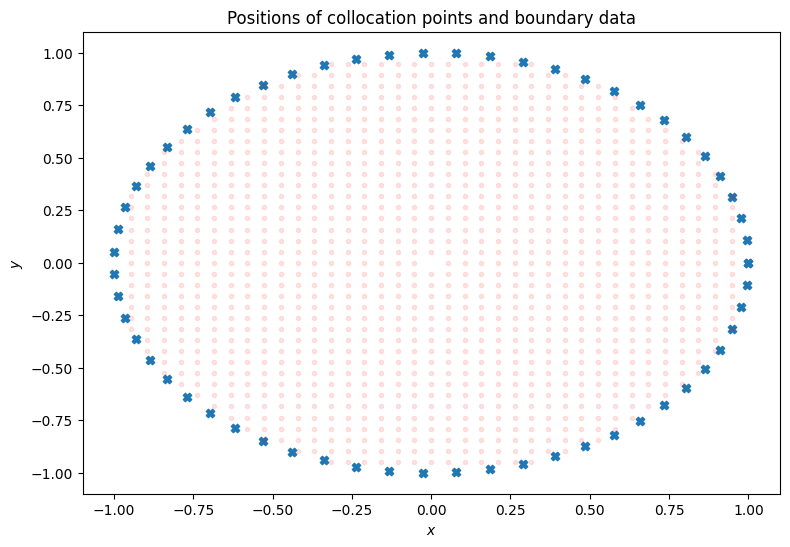

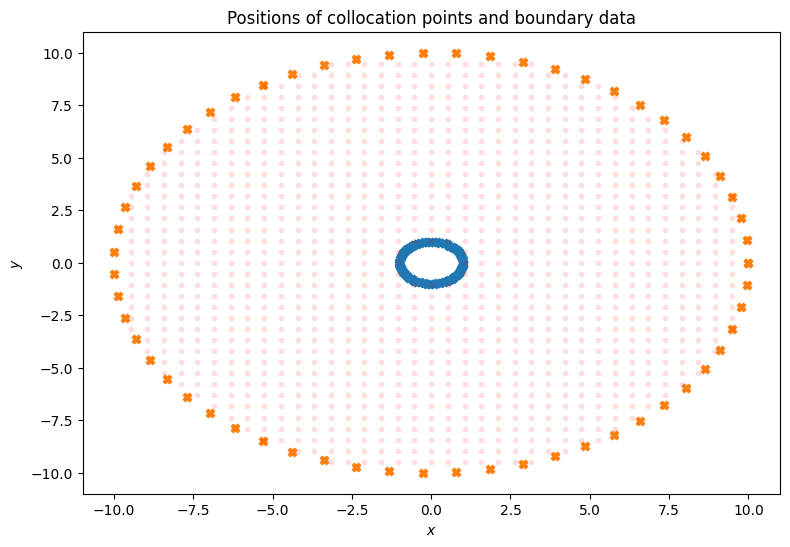

In [77]:
XPINN_solver = XPINN(PINN)

domain1 = ([-1,1],[-1,1])
PDE1 = PDE_Model()
domain1 = PDE1.set_domain(domain1)
PDE1.sigma = 0.04
PDE1.epsilon = 1

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1, 'rmin':0}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points();

PDE2 = PDE_Model_2()
domain2 = ([-10,10],[-10,10])
domain2 = PDE1.set_domain(domain2)
PDE2.sigma = 0.04
PDE2.epsilon = 10

vf = (1/(2*np.pi*PDE2.epsilon))*np.log(10)
lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
lb2 = {'type':'D', 'value':vf, 'fun':None, 'dr':None, 'r':10}
borders = {'1':lb,'2':lb2}
ins_domain = {'rmax': 10,'rmin':1}

mesh2 = Mesh(domain2, N_b=60, N_r=1500)
mesh2.create_mesh(borders, ins_domain)
mesh2.plot_points();

XPINN_solver = XPINN(PINN)

XPINN_solver.adapt_PDEs([PDE1,PDE2],[1,10])
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
XPINN_solver.adapt_meshes([mesh1,mesh2],[weights,weights])

lr = ([1000],[1e-2,5e-3])
hyperparameters = {
        'input_shape': (None,2),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

XPINN_solver.load_NeuralNets('.saved_models',['Test_precond_in','Test_precond_ext'],[lr,lr])

In [78]:
Post = View_results_X(XPINN_solver,View_results)

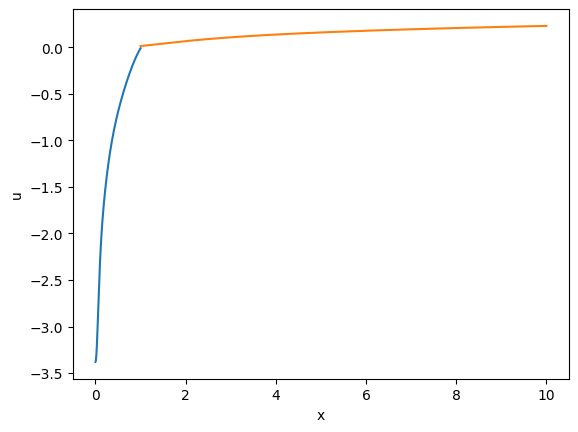

In [79]:
Post.plot_u_plane()

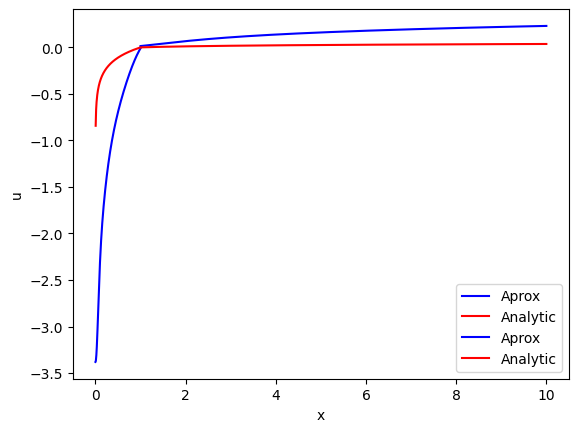

In [80]:
Post.plot_aprox_analytic()

In [81]:
XPINN_solver.solve(N=1500, flag_time=False)

In [82]:
Post = View_results_X(XPINN_solver,View_results)

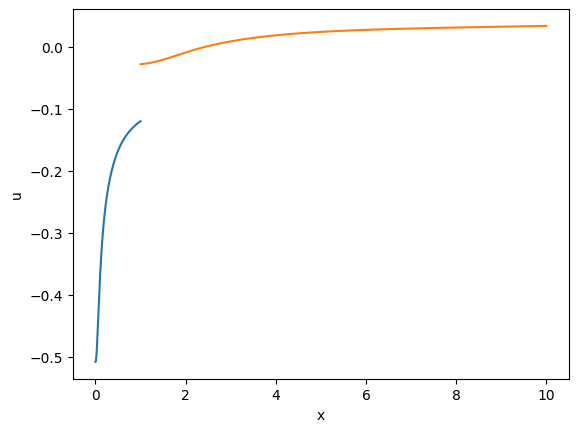

In [83]:
Post.plot_u_plane()

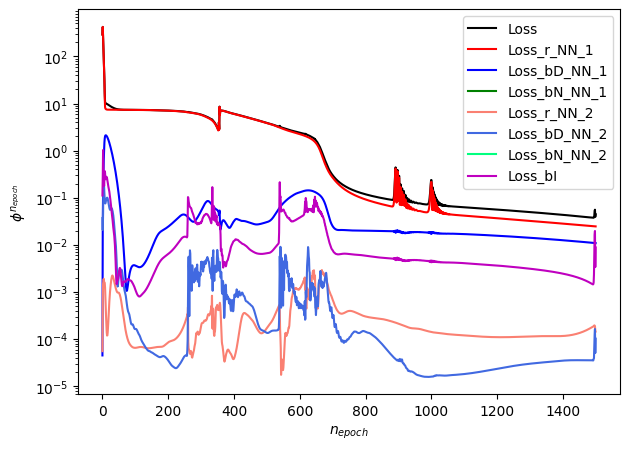

In [84]:
Post.plot_loss_history();

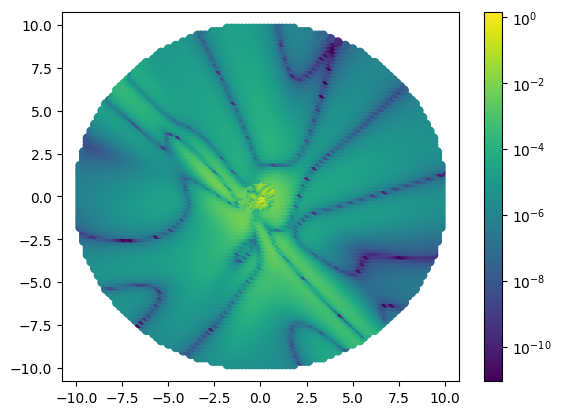

In [85]:
Post.plot_loss()

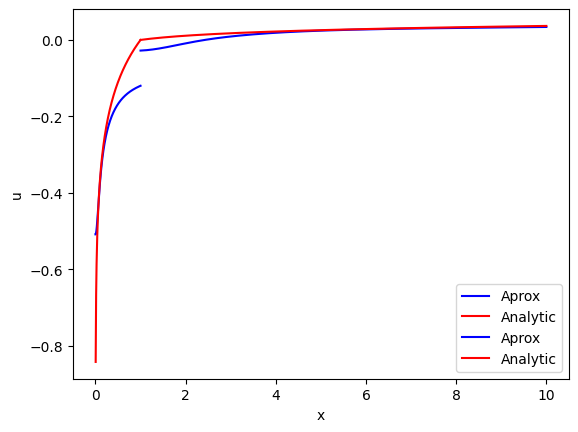

In [86]:
Post.plot_aprox_analytic()

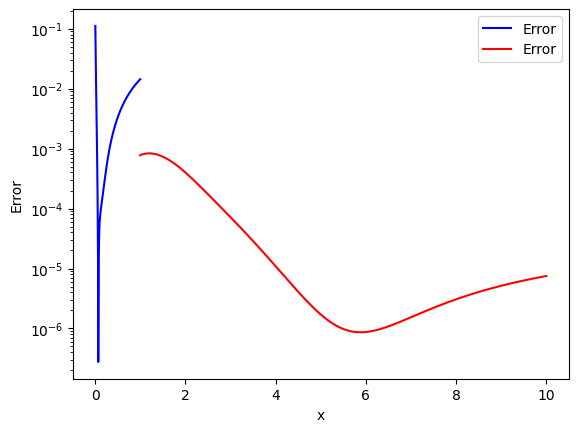

In [87]:
Post.plot_loss_analytic()

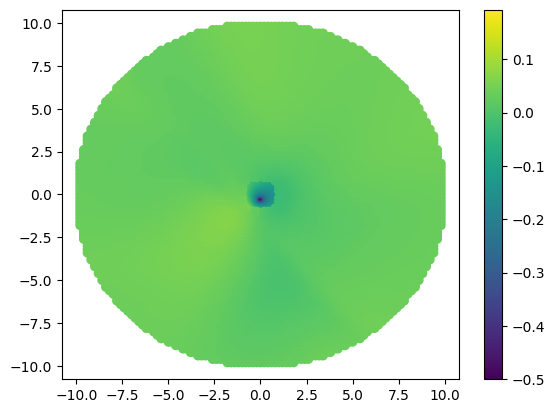

In [88]:
Post.plot_u_domain_contour()

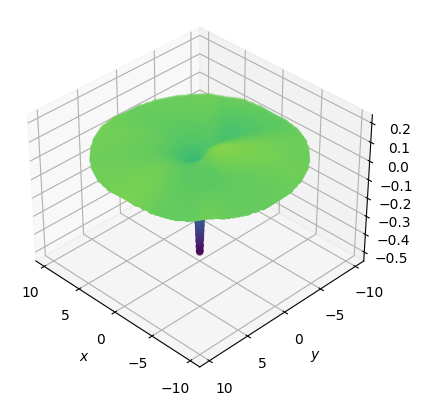

In [89]:
Post.plot_u_domain_surface()